## Applied Data Science Capstone Project - The Battle of Neighborhoods

### Introduction/Business Problem

An investor is looking to open a new restaurant in San Francisco, but he is not sure about the best location for his new venue and needs input for making the decision. San Francisco is rather busy city famous for its business innovation and several famous tourit attractions. So while it looks promising to set up a new restaurant business in San Francisco, the venue's location must be carefully picked in order to maximize the profit. According to <a href="https://www.foodnewsfeed.com/fsr/vendor-bylines/8-factors-choosing-new-restaurant-location">an analysis</a> in the FSR Magazine, the 8 factors for choosing a new restaurant location are

1. Visibility - look for foot and car traffic patterns that can give the venue the best visibility.
2. Parking - need to have sufficient parking space for customers.
3. Space size - consider how big of a space one needs for restaurant requirements.
4. Crime rates - avoid crime-laden areas in the city.
5. Surrounding businesses and competitor analysis - know what types of restaurant would do well in a certain area. Know what will distinguish a new restaurant from competitors.
6. Acessibility - keep in mind about things like off-the-hightway locations, locations near busy intersections.
7. Affordability - the cost of the venue space (rental or purchase) is a bottom-line consideration for any business.
8. Safety - workplace safty is important for the restaurant owner as well as workers.

In the capstone project, we will get the help from FourSquare API to address these considerations. 

### Data

Because of the availability of datasets, we will not address all of the factors listed above. However, we will work on some of the most important factors such as visibility, parking, crime rates, and affordability. We will utilize the following datasets/tools.

Static datasets:

1. Police Department Incident Reports: 2018 to Present (<a href="https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783">Link</a>). The dataset includes police incident reports filed by officers and by individuals through self-service online reporting for non-emergency cases. Reports included are those for incidents that occurred starting January 1, 2018 onward and have been approved by a supervising officer. 
2. MTA On Street Parking Census (<a href="https://data.sfgov.org/Transportation/MTA-parkingcensus_onstreet/up9y-3nmx">Link</a>). The dataset contains locations and space count of unmetered motorcycle parking for the City of San Francisco.
3. MTA Off Street Parking Census (<a href="https://data.sfgov.org/Transportation/MTA-parkingcensus_offstreet/dkzc-uy8h">Link</a>). SFMTA managed off street parking locations, hours, and amenities. Includes both lots and garages.	
4. San Francisco Historica Secured Property Tax Rolls, 2007-2015 (<a href="https://www.kaggle.com/datasf/sf-historic-secured-property-tax-rolls">Link</a>). This dataset includes the SF Office of the Assessor-Recorder’s secured property tax roll spanning from 2007 to 2015. We will use the latest data as a measure of the cost of venue space.

Search engines:
1. <a href="https://foursquare.com/">Foursquare</a>. We will use the foursquare API to carry out venue and point of interest search. The results will give us an idea of the neighborhood of the venue's potential location.
2. <a href="https://www.parkwhiz.com/">PARKWHIZ</a>. We intend to use the static dataset to look up parking space information near the potential venue location. PARKWHIZ is a quick and convenient alternative.

In [50]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt

from geopandas.tools import sjoin
from geopy.geocoders import Nominatim

%matplotlib inline

In [2]:
crime_data_path = "./Police_Department_Incident_Reports__2018_to_Present.csv"

In [3]:
df_crime = pd.read_csv(crime_data_path)

In [4]:
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111531 entries, 0 to 111530
Data columns (total 26 columns):
Incident Datetime          111531 non-null object
Incident Date              111531 non-null object
Incident Time              111531 non-null object
Incident Year              111531 non-null int64
Incident Day of Week       111531 non-null object
Report Datetime            111531 non-null object
Row ID                     111531 non-null int64
Incident ID                111531 non-null int64
Incident Number            111531 non-null int64
CAD Number                 86415 non-null float64
Report Type Code           111531 non-null object
Report Type Description    111531 non-null object
Filed Online               23641 non-null object
Incident Code              111531 non-null int64
Incident Category          111520 non-null object
Incident Subcategory       111520 non-null object
Incident Description       111531 non-null object
Resolution                 111531 non-null ob

Remove columns that are not needed for analysis and visualization.

In [5]:
columns = ['Incident Datetime', 'Report Datetime', 'CAD Number', 'Report Type Code', 'Report Type Description', 'Filed Online', 'Intersection', 'CNN', 
       'Analysis Neighborhood', 'Supervisor District', 'Resolution', 'point']
df_crime = df_crime.drop(columns, axis=1)

In [6]:
df_crime.isnull().sum()

Incident Date              0
Incident Time              0
Incident Year              0
Incident Day of Week       0
Row ID                     0
Incident ID                0
Incident Number            0
Incident Code              0
Incident Category         11
Incident Subcategory      11
Incident Description       0
Police District            0
Latitude                5575
Longitude               5575
dtype: int64

Dropping rows that contain NaNs.

In [7]:
df_crime = df_crime.dropna(subset=df_crime.columns)
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105945 entries, 0 to 111494
Data columns (total 14 columns):
Incident Date           105945 non-null object
Incident Time           105945 non-null object
Incident Year           105945 non-null int64
Incident Day of Week    105945 non-null object
Row ID                  105945 non-null int64
Incident ID             105945 non-null int64
Incident Number         105945 non-null int64
Incident Code           105945 non-null int64
Incident Category       105945 non-null object
Incident Subcategory    105945 non-null object
Incident Description    105945 non-null object
Police District         105945 non-null object
Latitude                105945 non-null float64
Longitude               105945 non-null float64
dtypes: float64(2), int64(5), object(7)
memory usage: 12.1+ MB


In [8]:
df_crime['Incident Category'].unique()

array(['Robbery', 'Fire Report', 'Assault', 'Malicious Mischief',
       'Larceny Theft', 'Non-Criminal', 'Miscellaneous Investigation',
       'Disorderly Conduct', 'Warrant', 'Weapons Carrying Etc',
       'Recovered Vehicle', 'Other Miscellaneous', 'Burglary',
       'Missing Person', 'Suspicious Occ', 'Civil Sidewalks', 'Fraud',
       'Motor Vehicle Theft', 'Traffic Violation Arrest', 'Drug Offense',
       'Weapons Offense', 'Offences Against The Family And Children',
       'Stolen Property', 'Lost Property', 'Other Offenses',
       'Traffic Collision', 'Suicide', 'Homicide', 'Vehicle Misplaced',
       'Other', 'Family Offense', 'Forgery And Counterfeiting',
       'Sex Offense', 'Arson', 'Courtesy Report', 'Case Closure',
       'Gambling', 'Drug Violation', 'Prostitution', 'Juvenile Offenses',
       'Embezzlement', 'Vehicle Impounded', 'Vandalism',
       'Human Trafficking (A), Commercial Sex Acts', 'Liquor Laws',
       'Suspicious', 'Motor Vehicle Theft?', 'Rape', 'Weapo

In [9]:
df_crime['Incident Category'].value_counts()

Larceny Theft                                 31309
Other Miscellaneous                            8844
Non-Criminal                                   7074
Assault                                        6726
Malicious Mischief                             6187
Burglary                                       5233
Warrant                                        4066
Motor Vehicle Theft                            3675
Missing Person                                 3265
Lost Property                                  3185
Fraud                                          3062
Drug Offense                                   2877
Robbery                                        2660
Offences Against The Family And Children       2424
Recovered Vehicle                              2287
Suspicious Occ                                 2000
Disorderly Conduct                             1839
Traffic Violation Arrest                       1541
Miscellaneous Investigation                     929
Other Offens

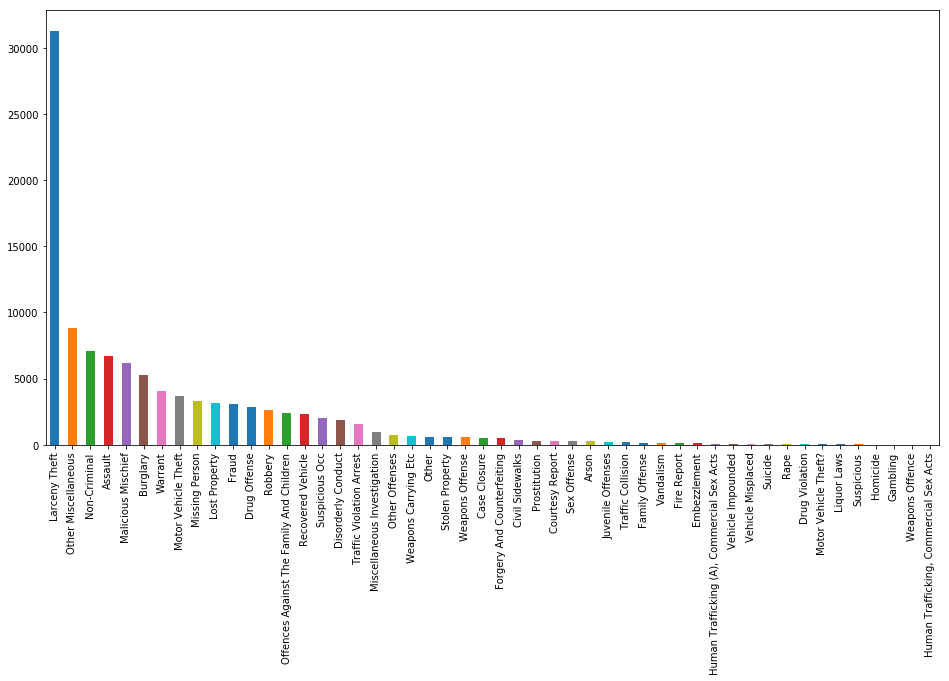

In [10]:
df_crime['Incident Category'].value_counts().plot(kind='bar', figsize=(16,8))
plt.show()

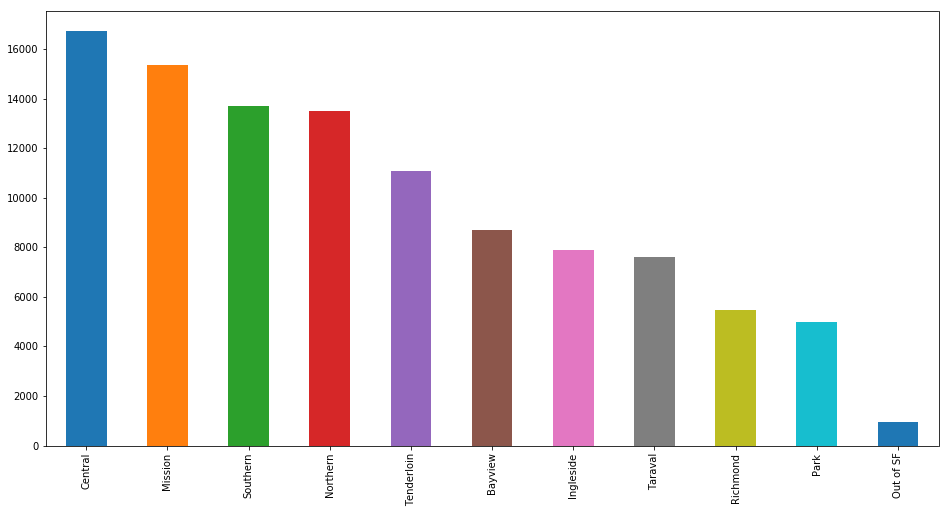

In [11]:
df_crime['Police District'].value_counts().plot(kind='bar', figsize=(16,8))
plt.show()

In [12]:
# Query San Francisco GPS coordinates.

#address = 'San Francisco, CA, USA'
#geolocator = Nominatim(user_agent="my-application")
#location = geolocator.geocode(address)
#latitude = location.latitude
#longitude = location.longitude
#print(latitude)
#print(longitude)

In [13]:
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [39]:
# Define San Francisco GPS location. This information can be acquired using the query in the last cell.
SF_Coord = (37.7792808, -122.4192363)

SF_map1 = folium.Map(location=SF_Coord, zoom_start=12)

# Fech part of the dataset for demonstration purpose. This would speedup the folium map generation time.
Max_Records = 3000
df = df_crime[:Max_Records]

SF_map1.add_child(FastMarkerCluster(df[['Latitude', 'Longitude']].values.tolist()))
SF_map1

In [47]:
# definition of the boundaries in the map
district_geo = r'SF_PD_District.geojson'
  
# calculating total number of incidents per district
crimedata = pd.DataFrame(df_crime['Police District'].value_counts().astype(float))
crimedata = crimedata.reset_index()
crimedata.columns = ['District', 'Number']

# Convert district names to all capitals in order to match the geojson file.
crimedata['District'] = crimedata['District'].str.upper()
  
# creation of the choropleth
SF_map2 = folium.Map(location=SF_Coord, zoom_start=12)
SF_map2.choropleth(geo_data     = district_geo, 
                   data         = crimedata,
                   columns      = ['District', 'Number'],
                   key_on       = 'feature.properties.DISTRICT',
                   fill_color   = 'YlOrRd', 
                   fill_opacity = 0.75, 
                   line_opacity = 0.55,
                   legend_name  = 'Number of incidents'
                  )
SF_map2

In [48]:
crimedata

,District,Number
0,CENTRAL,16710.0
1,MISSION,15357.0
2,SOUTHERN,13711.0
3,NORTHERN,13490.0
4,TENDERLOIN,11080.0
5,BAYVIEW,8685.0
6,INGLESIDE,7893.0
7,TARAVAL,7595.0
8,RICHMOND,5478.0
9,PARK,4981.0


In [59]:
tracts = gpd.read_file('geo_export_628f60d8-b0c4-4580-9180-ac3fad9e86ea.shp')

In [60]:
tracts.columns

Index(['nhood', 'geometry'], dtype='object')

In [61]:
tracts

,nhood,geometry
0,Bayview Hunters Point,POLYGON ((-122.3815777424142 37.75307043091241...
1,Bernal Heights,"POLYGON ((-122.403612999828 37.74933700015653,..."
2,Castro/Upper Market,POLYGON ((-122.4265550005568 37.76948499984702...
3,Chinatown,POLYGON ((-122.4062259995664 37.79755900029376...
4,Excelsior,POLYGON ((-122.4239820002333 37.73155199975518...
5,Financial District/South Beach,(POLYGON ((-122.3875252162534 37.7827973443872...
6,Glen Park,"POLYGON ((-122.447375000173 37.74648199962739,..."
7,Inner Richmond,POLYGON ((-122.4593239995408 37.78752100021499...
8,Golden Gate Park,"POLYGON ((-122.4409220004132 37.773634999987, ..."
9,Haight Ashbury,POLYGON ((-122.4319979995735 37.77143099965404...
